## Starting my own model

In [1]:
import pandas as pd
import pickle
from gensim.models.phrases import Phrases, Phraser

import time

import multiprocessing

from gensim.models import Word2Vec

from sqlitedict import SqliteDict

from datetime import datetime
import numpy as np

In [2]:
name = "left-center"

In [7]:

pua_clean = SqliteDict(f"{name}_clean.sqlite", tablename="value", flag="r")

In [3]:
pua_clean_csv = pd.read_pickle(f"{name}.sqlite_clean.csv")

In [4]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [5]:
cores

16

In [6]:
parameters = dict(min_count=3,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores)

### Google Model

In [71]:
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
google_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [72]:
google_model.most_similar(positive=["man"])

[('woman', 0.7664012312889099),
 ('boy', 0.6824870705604553),
 ('teenager', 0.6586930155754089),
 ('teenage_girl', 0.6147903800010681),
 ('girl', 0.5921714305877686),
 ('suspected_purse_snatcher', 0.571636438369751),
 ('robber', 0.5585119724273682),
 ('Robbery_suspect', 0.5584410429000854),
 ('teen_ager', 0.5549196600914001),
 ('men', 0.5489762425422668)]

In [ ]:
values = pua_clean_csv.clean
type(values)

## Community Models

In [7]:
sub_sent = []
c = 0
clean = np.array(pua_clean_csv.clean)
for value in clean:

    if c%1000000==0:
        print(c)
    if(value != None):
        sub_sent.append(value.split())
    c+=1
print("iter")
sub_phrases = Phrases(sub_sent, min_count=3)
print("phrases")
sub_bigram = Phraser(sub_phrases)
print("bigram")
sub_sentences = sub_bigram[sub_sent]
print("sentences")
print("Start model")

with open(f"{name}_sentences.txt", "wb") as fp:  # Pickling
    pickle.dump(sub_sentences, fp)
print(f'{name}_sentences.txt created')



0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
iter
phrases
bigram
sentences
Start model


NameError: name 'sub' is not defined

In [8]:
Model = Word2Vec(**parameters)
Model.build_vocab(sub_sentences)


In [9]:
Model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)
Model.train(sub_sentences, total_examples=Model.corpus_count, epochs=30)

Model.init_sims(replace=True)
Model.wv.save(f"{name}_wordvectors.kv")
print(f"{name}_wordvectors.kv saved")

right_wordvectors.kv saved


In [10]:
t = 0
for v in pua_clean:
    print(pua_clean[v])
    t += 1
    if t ==10:
        break

{'text': None, 'timestamp': 1550729531616}
{'text': 'dem care hope party die time change', 'timestamp': 1550729531617}
{'text': 'wow debbie need new blood treatment nancy take debbie look horrible suffer progressive cognitive dissonance', 'timestamp': 1550729531618}
{'text': 'interesting fact debbie dingell year old husband john dingell enter congress interestingly husband john dingell married wife year debbie bear odd', 'timestamp': 1550729531619}
{'text': 'debbie chock lie', 'timestamp': 1550729531620}
{'text': 'reporter poor old debbie', 'timestamp': 1550729531621}
{'text': 'woman look sound like wake car outside bar drive interview', 'timestamp': 1550729531622}
{'text': "dumbacrat blah blah blah talk circle let room ' discussion ' lmfao pay increase welfare leech hop fence month pregnant stuff newborn fence change law say soil hearing stop welfare human leech magnet food stamp free medical month pregnant fence jumper etccccccccccccccccccccccccccc open heart surgery x bypass stent m

In [20]:
to_request

[]

## Time models

In [10]:
def time_model_creation(model_sqlite, community):
    
    models = []
    years = []
    d = dict()
    sub = community
    year_sqlite = SqliteDict(f"{community}_years.sqlite", tablename="value", journal_mode="OFF")
    for id_c in model_sqlite:
        try:
            value = model_sqlite[id_c]
            dt_object = datetime.fromtimestamp(value["timestamp"]//1000)

            if dt_object.year not in years:
                print(dt_object.year)
                d[dt_object.year] = []
                years.append(dt_object.year)

            if value["text"] != None:
                d[dt_object.year].append(value["text"].split())
        except:
            print("ue")
            continue
                
    model_sqlite.close()
    print(years)
    
    for key, value in d.items():
        year_sqlite[key] = value
        
    year_sqlite.commit()
        
    for year in years:

        time_sent = year_sqlite[year]
        
        if len(time_sent) == 0:
            print(f"year {year} not found")
            continue
            
        time_phrases = Phrases(time_sent, min_count=3)
        time_bigram = Phraser(time_phrases)
        time_sentences = time_bigram[time_sent]
       
        with open(f"./../topic_model/data/{sub}_sentences_{year}.txt", "wb") as fp:  # Pickling
            pickle.dump(time_sentences, fp)
        print(f'{sub}_sentences_{year}.txt created')
        
        # Creating time Model
        Model = Word2Vec(**parameters)
        Model.build_vocab(time_sentences)
        Model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)
        Model.train(time_sentences, total_examples=Model.corpus_count, epochs=30)
        
        Model.init_sims(replace=True)
        Model.wv.save(f"{sub}_wordvectors_{year}.kv")
        
        models.append(Model)
        
        print(f"Created {sub}_wordvectors_{year}.kv")

In [ ]:
time_model_creation(pua_clean, "right")

2019
2018
2012
2017
2010
2016
2011
2013
2015
2008
2014
2009
ue
2007
ue
ue


In [1]:
import pandas as pd

In [4]:
pd.DataFrame(columns={'oi':'a', 'ai':'b'})

,oi,ai


In [5]:
import pickle

In [ ]:
pickle.dump(protocol=)

## Comparing community models

In [41]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set()

In [42]:
def make_graph(model, word):
    G = nx.Graph()
    G.add_node(word)
    
    for close_word in model.most_similar(positive=[word], topn=5):
        close_word=close_word[0]
        G.add_node(close_word)
        G.add_edge(word, close_word)
        G[word][close_word]['weight'] = model.similarity(word, close_word) * 1000
        
        for other_word in model.most_similar(positive=[close_word], topn=3):
            other_word = other_word[0]
            G.add_node(other_word)
            G.add_edge(close_word, other_word)
            G[close_word][other_word]['weight'] = model.similarity(close_word, other_word) * 1000
    return G

* Cos similarity multiplied by 1000 to improve Fruchterman-Reingold force-directed algorithm

In [44]:
def comparing_models(models, word, titles=['First 1%', 'Last 1%'],
                     seed=6, rows=2, cols=2, suptitle='Reddit Communities'):

    Gs = [make_graph(model, word) for model in models]

    nr_rows = rows
    nr_cols = cols
    
    fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*8,nr_rows*4), squeeze=False)
    plt.suptitle(suptitle, y=0.95, fontsize=15)

    for r in range(0,nr_rows):
        for c in range(0, nr_cols):  
            col = r*nr_cols+c
            if col < len(models):
                color = ['yellow']
                color.extend(['skyblue']*(len(Gs[col].nodes)-1))
                
                axs[r][c].set(title=titles[col])
                nx.draw(Gs[col], pos=nx.spring_layout(Gs[col], seed=seed), with_labels=True,
                        node_color = color, font_size=12, ax=axs[r][c])


In [45]:
def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [46]:
def print_similar(models, word, model_names=["MR", "Incel", "MGTOW", "RedPill", "Google"], n=10, comparing="Reddit"):
    d = {}
    for i in range(len(models)):
        t = models[i].most_similar(positive=[word], topn=n)
        d[model_names[i]] = [t[j][0] for j in range(n)]
        
    df = pd.DataFrame(d)
    print(f'Words most similar to {word} on {comparing}')
    return df

In [62]:
def plot_cossim(word1, word2, models, communities=["MR", "Incel", "MGTOW", "RedPill"], comparing="Reddit"):
    x = communities
    y = [model.similarity(word1, word2) for model in models]
    fig, ax = plt.subplots()
    ax.set(title=(f'Cossim between {word1} and {word2} on {comparing}'))
    sns.pointplot(x, y, ax=ax);

In [82]:
def google_cossim(word, models, google_model, communities=["MR", "Incel", "MGTOW", "RedPill"], comparing="reddit"):
    x = communities
    y = [cos_sim(model.__getitem__(word), google_model.__getitem__(word)) for model in models]
    fig, ax = plt.subplots()
    ax.set(title=(f'Cossim of {word} in google model and in {comparing} model'))
    sns.pointplot(x, y, ax=ax);

In [52]:
from gensim.models import KeyedVectors

pua_model = KeyedVectors.load("pua_wordvectors.kv", mmap='r')

#### Table of most similar words 

In [63]:
word = 'woman'
n = 10
models = [pua_model]
print_similar(models, word, n=n, comparing='Alt Righters Reddits')

Words most similar to woman on Alt Righters Reddits


,MR
0,man
1,teenage_girl
2,fall_love
3,feel_secure
4,female
5,take_advantage
6,someone
7,teenager
8,upper_hand
9,high_value


#### Cos Similarity between two words in each community

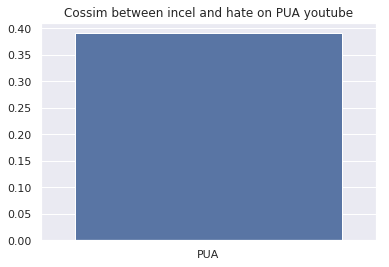

In [58]:
word1 = 'incel'
word2 = 'hate'
models = [pua_model]
plot_cossim(word1, word2, models, communities=["PUA"], comparing="PUA youtube")

#### Cos Similarity between word in each community and in google (how much that word changes)

* Words used rarely change less than frequently used words

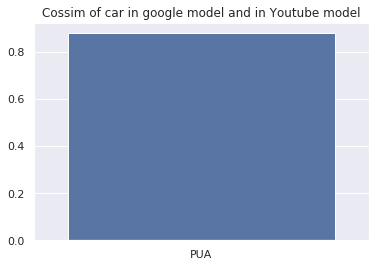

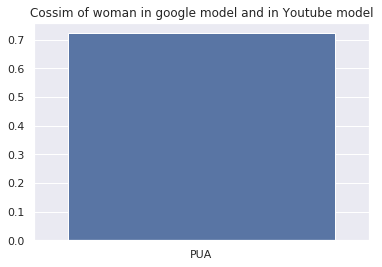

In [65]:
word1 = 'car'
word2 = 'woman'
models = [pua_model]
google_cossim(word1, models, google_model, communities=["PUA"], comparing="Youtube")
google_cossim(word2, models, google_model, communities=["PUA"], comparing="Youtube")


#### Graph of closest words for each community

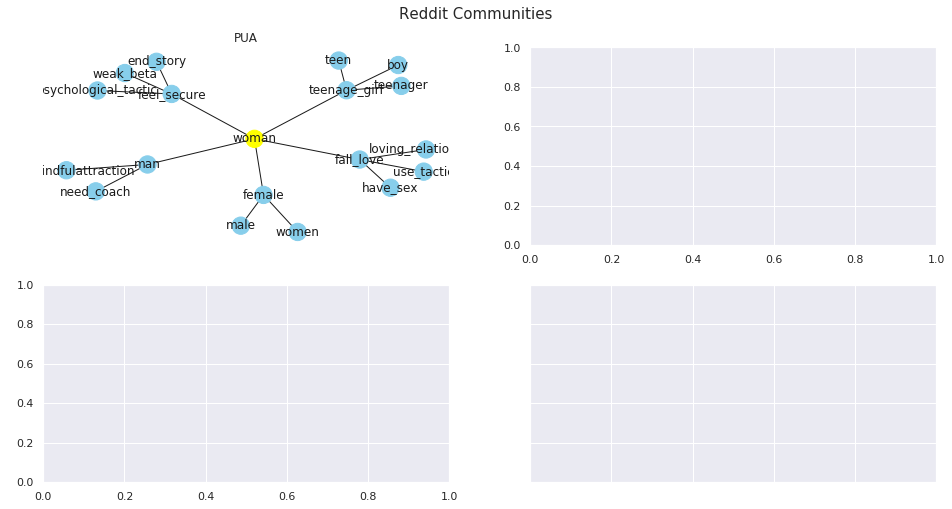

In [66]:
word = 'woman'
comparing_models(models, word, titles=["PUA"])

## Comparing time models

In [75]:
from gensim.models import KeyedVectors

years = [2018, 2019]

In [76]:
years_str = list(map(str, years))

In [77]:
years_str

['2018', '2019']

In [78]:
Pua_models = []
for year in years:
    Pua_models.append(KeyedVectors.load(f"PUA_wordvectors_{year}.kv", mmap='r'))

#### Tables of most similar words by time for each community

In [79]:
# PUA
word = 'woman'
n = 10
print_similar(Pua_models, word, n=n, model_names=years_str, comparing='PUA')

Words most similar to woman on PUA


,2018,2019
0,man,man
1,person,girl
2,female,lady
3,girl,person
4,fall_love,female
5,beta_male,nice_guy
6,mind_game,fall_love
7,feel_secure,speak_truth
8,play_game,low_self
9,take_advantage,piece_shit


#### Cos Similarity of two words over time

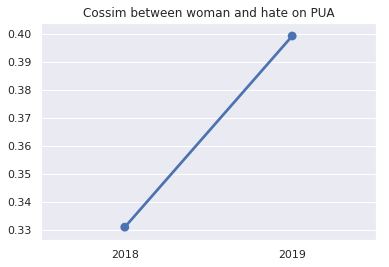

In [80]:
word1 = 'woman'
word2 = 'hate'
plot_cossim(word1, word2, Pua_models, communities=years_str, comparing="PUA")

#### Cos Similarity between a word in community model and google model by time (how much this word has changed over time)

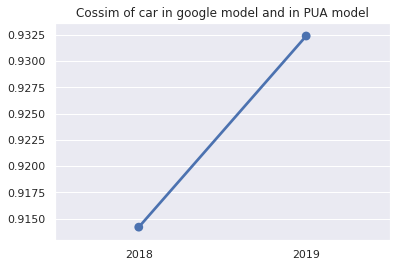

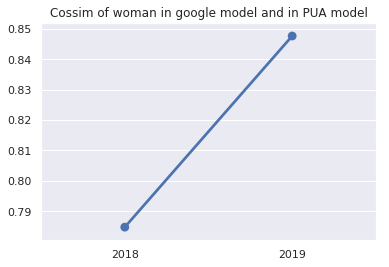

In [83]:
google_cossim('car', Pua_models, google_model, communities=years_str, comparing='PUA')
google_cossim('woman', Pua_models, google_model, communities=years_str, comparing='PUA')

#### Graph of closest words over time

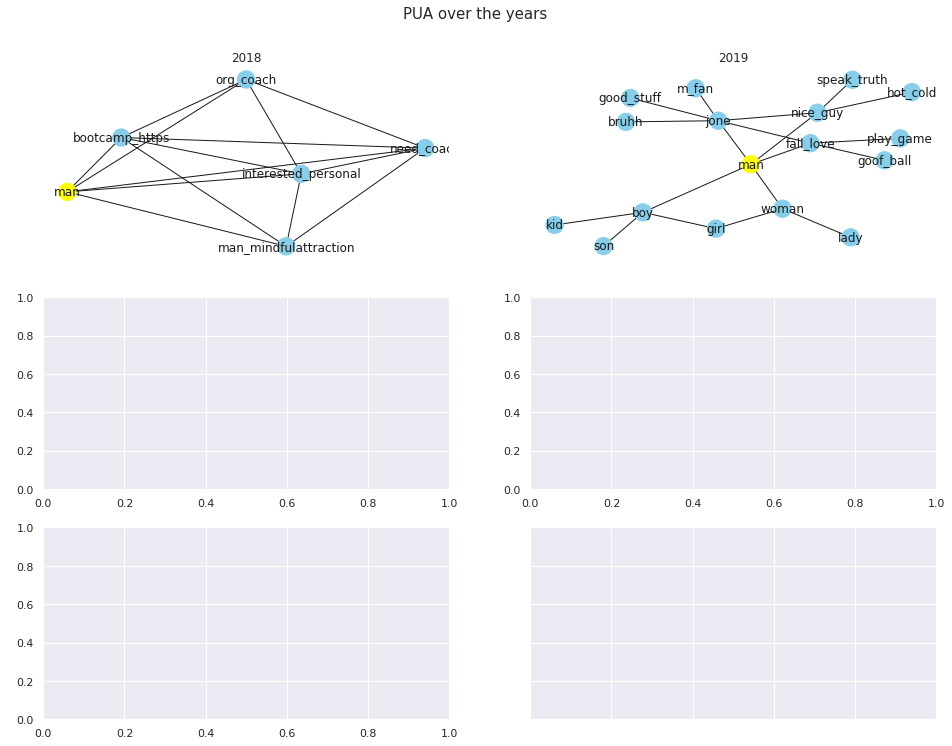

In [85]:
word = 'man'
comparing_models(Pua_models, word, titles=years_str, rows=3, cols=2, suptitle='PUA over the years')

##### T-SNE  Visualization algorithm (William L. Hamilton paper)

To visualize semantic change for a wordwiin twodimensions we employed the following procedure,which  relies  on  the  t-SNE  embedding  method(Van der Maaten and Hinton, 2008) as a subrou-tine:

* 1.  Find  the  union  of  the  wordwi’sknearestneighbors over all necessary time-points.
* 2.  Compute   the   t-SNE   embedding   of   thesewords on the most recent (i.e.,  the modern)time-point.
* 3.  For  each  of  the  previous  time-points,  holdall  embeddings  fixed,  except  for  the  targetword’s (i.e., the embedding forwi), and op-timize a new t-SNE embedding only for thetarget  word. We  found  that  initializing  theembedding for the target word to be the cen-troid  of  itsk′-nearest  neighbors  in  a  time-point was highly effective.

Thus, in this procedure the background words arealways shown in their “modern” positions, whichmakes sense given that these are the current mean-ings of these words. This approximation is neces-sary, since in reality all words are moving.

#### Aligning historical embeddings

We   use   orthogonal   Procrustes   to   align   thelearned  low-dimensional  embeddings.    DefiningW(t)∈Rd×|V|as the matrix of word embeddingslearned  at  yeart,  we  align  across  time-periodswhile preserving cosine similarities by optimizing:

$R(t)= arg   minQ>Q=I‖QW(t)−W(t+1)‖F $

The  solution  correspondsto  the  best  rotational  alignment  and  can  be  ob-tained  efficiently  using  an  application  of  SVD

##### Pair-wise  similarity  time-series

$ s(t)(wi,wj) =cos-sim(w(t)i,w(t)j) $

In [32]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline